# XPCS Analysis using PyXPCS

In [1]:
%load_ext autoreload
%autoreload

import numpy as np

# File reader 
from pyxpcs.reader import IMMReader8ID

# Configuration classes for loading metadata from HDF5 file
from pyxpcs.config import PyXPCSDict
from pyxpcs.utils import config_from_8idhdf5, load_results

# Simple visualization.
from pyxpcs.viz import plot_pix_sum, plot_as_image

# Computation function
from pyxpcs.algorithms import to_sparse_matrix, multitau

import matplotlib.pyplot as plt

from pprint import pprint

## Input Data

Specify the input IMM file to use. The result file from the xpcs-eigen analysis that contains G2, IP, and IF. The HDF5 file that will be used to run the pyxpcs analysis.

In [2]:
IMM_FILE = "A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_00001-00512.imm"
HDF5_FILE = "A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_0002-0512.hdf"

## Configuration

Load the configuration that are specific to 8-ID-I


In [3]:
config = config_from_8idhdf5(HDF5_FILE)
try:
    import pandas as pd
    df = pd.DataFrame.from_dict(config, orient='index')
    print(df)
except:
    pass

                                                                   0
rows                                                            1556
cols                                                             516
pixels                                                        802896
frame_start                                                        2
frame_end                                                        512
frame_start_limit                                                  2
frame_end_limit                                                  512
frames                                                           510
delays_per_level                                                   4
dqmap              [[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, ...
sqmap              [[269, 269, 269, 268, 268, 268, 267, 267, 267,...
roi_1d             [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...
beam_center_x                                                691.841
beam_center_y                     

## Load data


In [4]:
reader = IMMReader8ID(IMM_FILE,  # Input file
                      no_of_frames=config['frames'],  # Total number of frames to work with.
                      skip_frames=config['frame_start_limit'] # Frames to skip, typically specified in HDF5 file.
                     )

# Get the data read from the reader
indices, values = reader.data()
sparse_matrix = to_sparse_matrix(indices, values, config)

## Plotting

Basic plotting to verify the data is read properly.

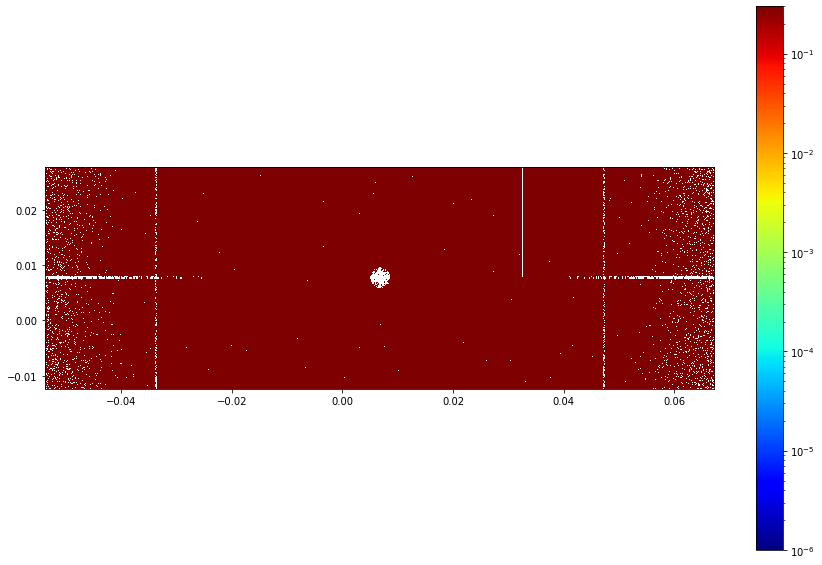

In [5]:
pixel_sum = np.zeros(config['cols'] * config['rows'])
for idx in range(len(indices)):
    pixel_sum[indices[idx]] += values[idx]

pixel_sum = np.reshape(pixel_sum, (config['cols'], config['rows']))
plot_pix_sum(pixel_sum, config)

## Analysis


### Sparse Matrix

Organized as list of list representations of sparse matrix. 


intensities = $$(f_5, f_4, \dots, f_{200}), (f_9, f_10, \dots, f_{150}) $$ 
indices = $$ (I_a, I_b) $$ 


As we are computing corelation that involves multiplying difference intensity values at a source index, and source + tau (step) index, we look them up using binaray search in the intensities array to speed up the computation. 

$$src\_index = i$$
$$dst\_index = i + tau$$

if dst_index found in binary_search(intensities):
    $$ G2(I_a, tau) += f_{src\_index} * f_{dst\_index}$$

In [6]:
G2, IP, IF = multitau(sparse_matrix, config)

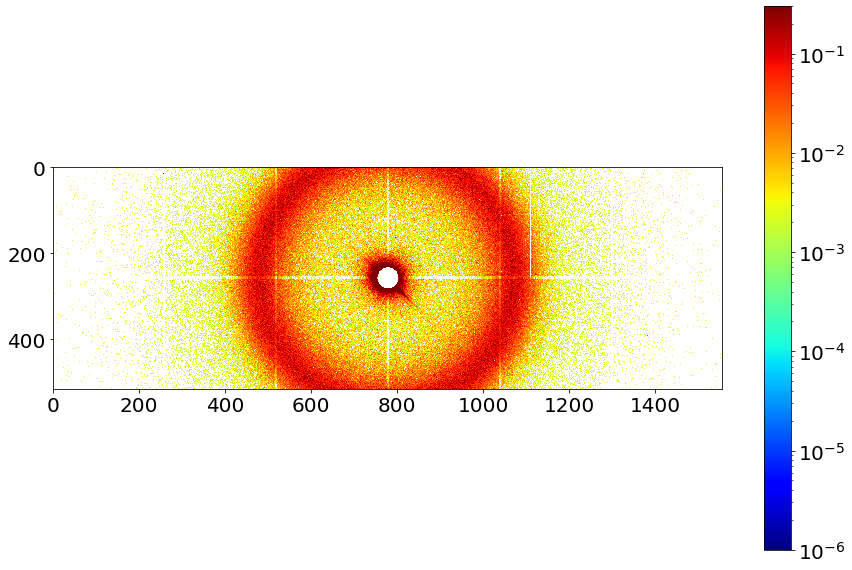

In [7]:
# In order to plot G2.
G2_plot = G2[0].reshape(config['cols'], config['rows'])
plot_as_image(G2_plot)

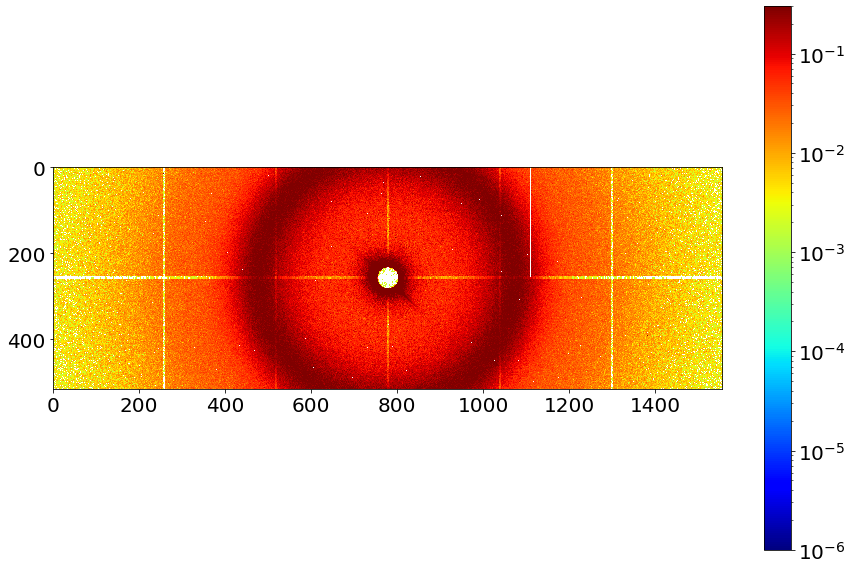

In [8]:
IP_plot = IP[0].reshape(config['cols'], config['rows'])
plot_as_image(IP_plot)

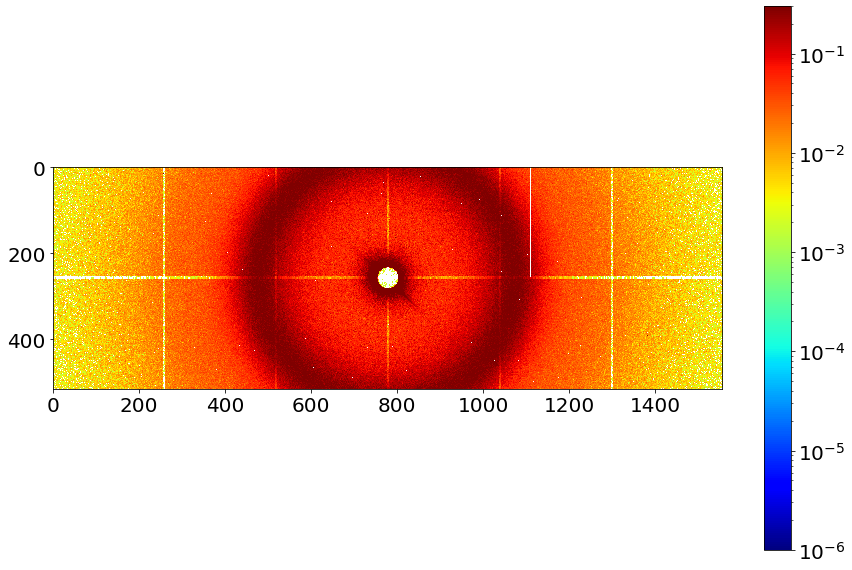

In [9]:
IF_plot = IF[0].reshape(config['cols'], config['rows'])
plot_as_image(IF_plot)

### g2 stderror

In [10]:
def compute_g2(G2, IP, IF, config):

    taus, pixels = G2.shape

    total_static_partitions = np.max(config['sqmap'])
    total_dynamic_partitions = np.max(config['dqmap'])
    
    # Final results
    g2 = np.zeros((taus, total_dynamic_partitions))
    g2_error = np.zeros((taus, total_dynamic_partitions))

    g2Sums = np.zeros((taus, total_static_partitions))
    ipSums = np.zeros((taus, total_static_partitions))
    ifSums = np.zeros((taus, total_static_partitions))

    dqmap = config['dqmap']
    sqmap = config['sqmap']


    IP_IF = IP * IF
    normalizedG2 = G2 /  (np.where( IP_IF != 0, IP_IF, 10000))

    # sum pixels for each static partitions
    for i in range(total_static_partitions):
        idx = (sqmap == i+1)
        g2Sums[:, i] = np.mean(G2[:, idx.flatten()], axis=1)
        ipSums[:, i] = np.mean(IP[:, idx.flatten()], axis=1)
        ifSums[:, i] = np.mean(IF[:, idx.flatten()], axis=1)

    ip_if_sums = ipSums * ifSums

    # Compute G2 error. 
    for i in range(total_dynamic_partitions):
        idx = (dqmap == i + 1)
        idx = idx.flatten()
        g2_error[:, i] = np.std(normalizedG2[:, idx], axis=1) / np.sqrt(pixels)

    for i in range(total_dynamic_partitions):
        low, high = np.amin(sqmap[dqmap == i+1]), np.max(sqmap[dqmap == i+1])
        tmp_g2_sum = g2Sums[:, low-1:high-1]
        g2[:, i] = np.mean(tmp_g2_sum / ip_if_sums[:, low-1:high-1], axis=1)
    
    return g2, g2_error

In [11]:
g2, g2_error = compute_g2(G2, IP, IF, config)

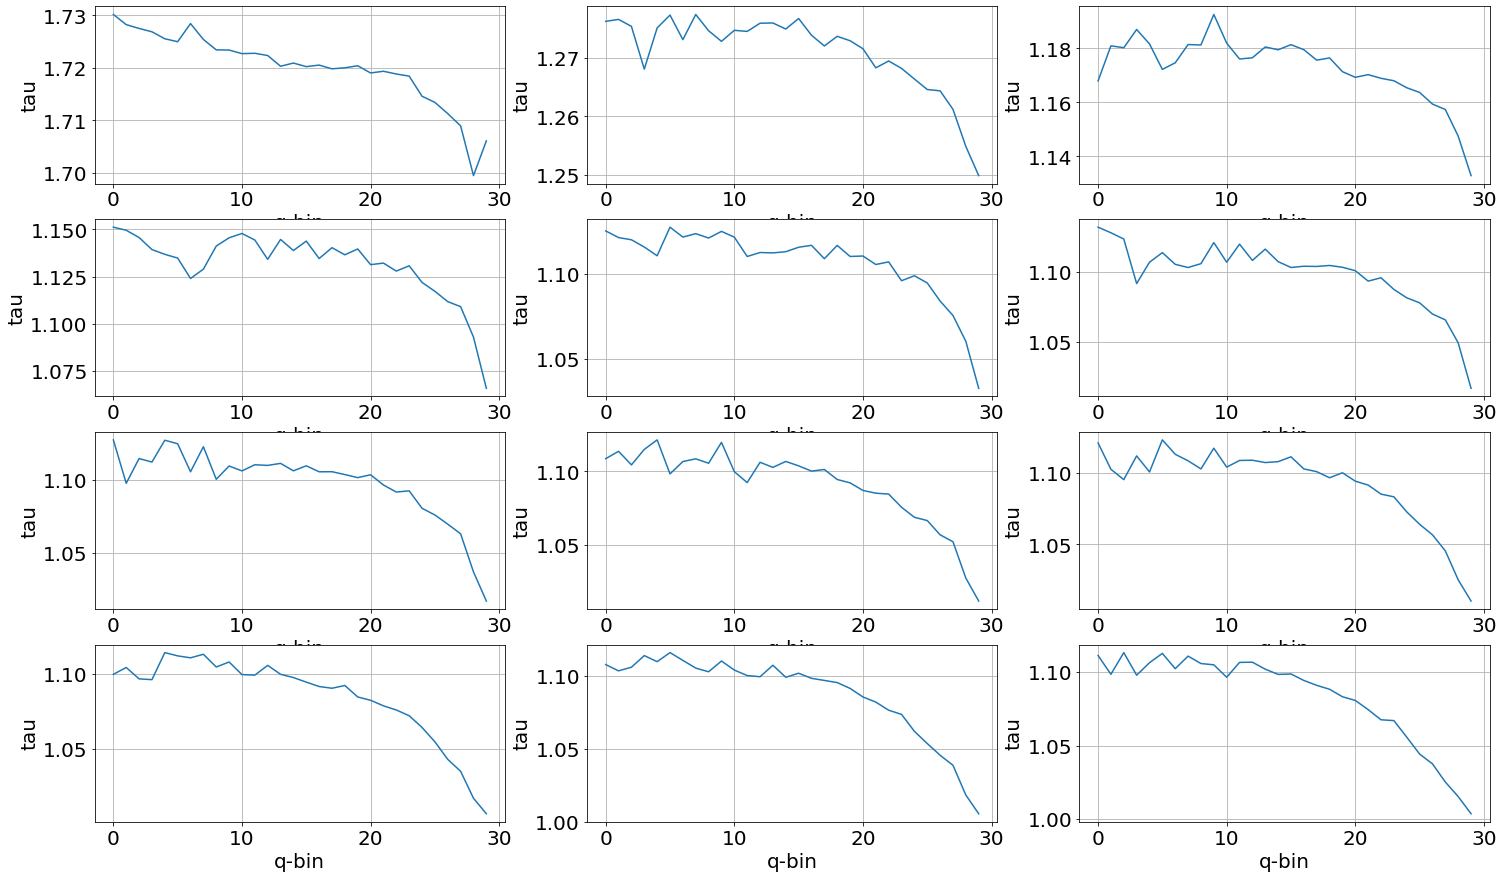

In [12]:
fig, m_axs = plt.subplots(4, 3, figsize=(25, 15))
[c_ax for c_ax in m_axs.flatten()]
idx = 0
for ax in m_axs:
    for ax2 in ax:
        ax2.plot(g2[:, idx])  
        ax2.set_xlabel('q-bin')
        ax2.set_ylabel('tau')
        ax2.grid(True)

        idx += 1